In [40]:
from datasets import load_dataset, load_from_disk, Dataset
import random
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from transformers import CLIPProcessor, CLIPModel
from datasets import Dataset
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
mscoco = load_dataset("clip-benchmark/wds_mscoco_captions")

Loading dataset shards:   0%|          | 0/27 [00:00<?, ?it/s]

In [3]:
mscoco_train= mscoco['train']

In [3]:
mscoco_test= mscoco['test']

In [4]:
mscoco_train


Dataset({
    features: ['__key__', '__url__', 'jpg', 'txt'],
    num_rows: 82783
})

In [4]:
def extract_first_caption(example):
    example["caption"] = example["txt"].split("\n")[0]
    return example

In [11]:
mscoco_train= mscoco_train.map(extract_first_caption)

Map:   0%|          | 0/82783 [00:00<?, ? examples/s]

In [6]:
mscoco_test= mscoco_test.map(extract_first_caption)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [8]:
mscoco_test[0]

{'__key__': 's0000000',
 '__url__': '/home/gusfysel@GU.GU.SE/.cache/huggingface/hub/datasets--clip-benchmark--wds_mscoco_captions/snapshots/3bf9ad5d280b03126293bcc691585015e29ce691/test/0.tar',
 'jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x478>,
 'txt': 'This wire metal rack holds several pairs of shoes and sandals\nA dog sleeping on a show rack in the shoes.\nVarious slides and other footwear rest in a metal basket outdoors.\nA small dog is curled up on top of the shoes\na shoe rack with some shoes and a dog sleeping on them',
 'caption': 'This wire metal rack holds several pairs of shoes and sandals'}

In [13]:
mscoco_train.save_to_disk("image_text_dataset")

Saving the dataset (0/28 shards):   0%|          | 0/82783 [00:00<?, ? examples/s]

In [11]:
mscoco_train = load_from_disk('image_text_dataset')

Loading dataset from disk:   0%|          | 0/28 [00:00<?, ?it/s]

In [13]:
shuffled_dataset = mscoco_train.shuffle(seed=42)
separation_point= len(shuffled_dataset) // 2

In [10]:
shuffled_test = mscoco_test.shuffle(seed=42)
separation_point= len(shuffled_test) // 2

In [11]:
def create_matching_pair(example):
    return {"image": example["jpg"], "caption": example["caption"], "label": 1}

In [15]:
matching_pairs = shuffled_dataset.select(range(separation_point)).map(create_matching_pair)

Map:   0%|          | 0/41391 [00:00<?, ? examples/s]

In [12]:
matching_pairs = shuffled_test.select(range(separation_point)).map(create_matching_pair)

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

In [16]:
matching_pairs.save_to_disk("matching")

Saving the dataset (0/9 shards):   0%|          | 0/41391 [00:00<?, ? examples/s]

In [19]:
captions = list(mscoco_train["caption"])
random.shuffle(captions)

In [16]:
captions= list(mscoco_test["caption"])
random.shuffle(captions)

In [17]:
def create_mismatched_pair(example, index, captions):
    return {"image": example["jpg"], "caption": captions[index], "label": 0}

In [18]:
def mismatched_pair_map(example, idx):
    return create_mismatched_pair(example, idx, captions)

In [23]:
mismatched_pairs = shuffled_dataset.select(range(separation_point, len(shuffled_dataset))).map(
    mismatched_pair_map,
    with_indices=True
)

Map:   0%|          | 0/41392 [00:00<?, ? examples/s]

In [19]:
mismatched_pairs = shuffled_test.select(range(separation_point, len(shuffled_test))).map(
    mismatched_pair_map,
    with_indices=True
)

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

In [20]:
combined_data = {
        "image": matching_pairs["image"] + mismatched_pairs["image"],
        "caption": matching_pairs["caption"] + mismatched_pairs["caption"],
        "label": matching_pairs["label"] + mismatched_pairs["label"],
    }


In [29]:
image_text_matching_ds = Dataset.from_dict(combined_data)

In [21]:
image_txt_matching_test = Dataset.from_dict(combined_data)

In [22]:
image_txt_matching_test = image_txt_matching_test.shuffle(seed=42)

In [31]:
image_text_matching_ds= image_text_matching_ds.shuffle(seed=42)

In [2]:
image_text_matching_ds.save_to_disk("image_text_dataset")

NameError: name 'image_text_matching_ds' is not defined

In [23]:
image_txt_matching_test.save_to_disk("image_text_test")

Saving the dataset (0/1 shards):   0%|          | 0/5000 [00:00<?, ? examples/s]

In [35]:
image_text_matching_ds[2]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x427>,
 'caption': 'A large kitchen with green walls and counters',
 'label': 0}

In [3]:
img_txt_ds = load_from_disk('image_text_dataset')

In [4]:
img_txt_test = load_from_disk('image_text_test')

In [6]:
img_txt_test[3]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=596x640>,
 'caption': 'A large gray elephant standing under a blue covering.',
 'label': 0}

In [7]:
image = img_txt_test[3]['image']

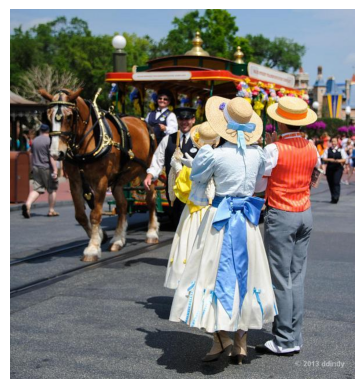

In [8]:
plt.imshow(image)
plt.axis('off') 
plt.show()

In [9]:
model_name = "openai/clip-vit-base-patch32"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

clip_model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)

/usr/local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
batch_size = 32
learning_rate = 5e-5
epochs = 5

In [11]:
def preprocess(example):
    processed = processor(
        text=example["caption"],
        images=example["image"],
        padding=True,
        truncation=True,
        return_tensors="pt",
    )
    processed["label"] = torch.tensor(example["label"])

    return processed

In [12]:
dataloader = DataLoader(
    img_txt_ds.with_transform(preprocess), batch_size=batch_size, shuffle=True
)

In [18]:
optimizer = torch.optim.AdamW(clip_model.parameters(), lr=learning_rate)
loss_fn = torch.nn.BCEWithLogitsLoss()

In [16]:
for batch in dataloader:
    print(batch['input_ids'].shape)
    print(batch['attention_mask'].shape)
    break

torch.Size([32, 18])
torch.Size([32, 18])


In [30]:
clip_model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in dataloader:
        inputs = {
            "input_ids": batch["input_ids"].to(device),
            "attention_mask": batch["attention_mask"].to(device),
            "pixel_values": batch["pixel_values"].to(device),
        }
        labels = batch["label"].to(device).float()

        outputs = clip_model(**inputs)
        logits_per_image = outputs.logits_per_image
        logits_per_image = torch.diag(logits_per_image)
        #print(logits_per_image.shape)
        
        # Binary Cross-Entropy Loss
        loss = loss_fn(logits_per_image, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print epoch loss
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")


Epoch 1/5, Loss: 0.3127
Epoch 2/5, Loss: 0.2867
Epoch 3/5, Loss: 0.2594
Epoch 4/5, Loss: 0.2273
Epoch 5/5, Loss: 0.1871


ValueError: You are trying to save a non contiguous tensor: `visual_projection.weight` which is not allowed. It either means you are trying to save tensors which are reference of each other in which case it's recommended to save only the full tensors, and reslice at load time, or simply call `.contiguous()` on your tensor to pack it before saving.

In [42]:
for param in clip_model.parameters():
    if not param.is_contiguous():
        param.data = param.data.contiguous()


In [43]:
clip_model.save_pretrained("fine_tuned_clip")
processor.save_pretrained("fine_tuned_clip_processor")

[]

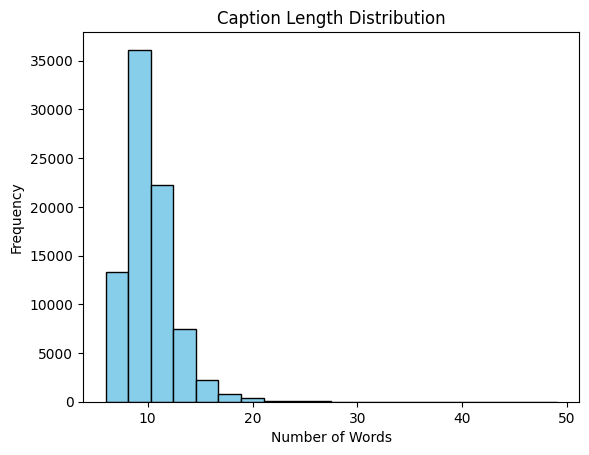

In [26]:
caption_lengths = [len(sample["caption"].split()) for sample in img_txt_ds]
plt.hist(caption_lengths, bins=20, color="skyblue", edgecolor="black")
plt.title("Caption Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

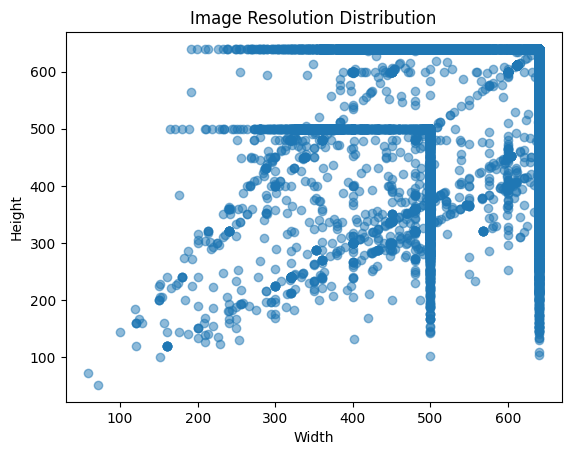

In [30]:
image_sizes = [sample["image"].size for sample in img_txt_ds]
widths, heights = zip(*image_sizes)
plt.scatter(widths, heights, alpha=0.5)
plt.title("Image Resolution Distribution")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()


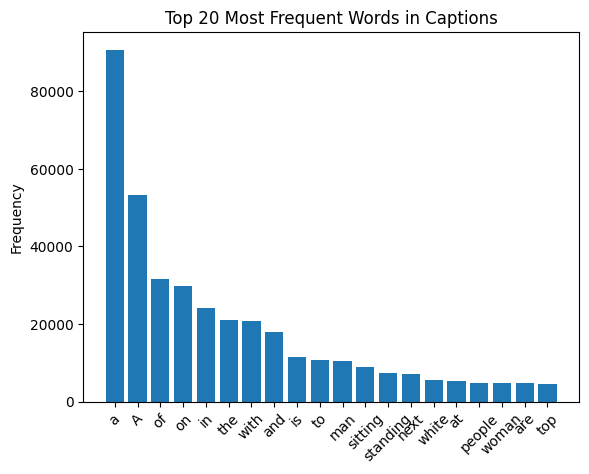

In [32]:
from collections import Counter

all_words = [word for sample in img_txt_ds for word in sample["caption"].split()]
word_counts = Counter(all_words).most_common(20)
words, counts = zip(*word_counts)
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top 20 Most Frequent Words in Captions")
plt.ylabel("Frequency")
plt.show()


In [ ]:
fine_tuned_model = CLIPModel.from_pretrained("fine_tuned_clip").to(device)
processor = CLIPProcessor.from_pretrained("fine_tuned_clip_processor")

In [32]:
batch_size = 16
test_dataloader = DataLoader(
    img_txt_test.with_transform(preprocess), batch_size=batch_size, shuffle=False
)

In [ ]:
fine_tuned_model.eval()

In [46]:
total_correct = 0
total_samples = 0
all_labels = []  
all_preds = []

with torch.no_grad():  
    for batch in test_dataloader:
        inputs = {
            "input_ids": batch["input_ids"].to(device),
            "attention_mask": batch["attention_mask"].to(device),
            "pixel_values": batch["pixel_values"].to(device),
        }
        labels = batch["label"].to(device).float()

        outputs = fine_tuned_model(**inputs)
        logits_per_image = outputs.logits_per_image  
        logits_per_image = torch.diag(logits_per_image)  

        predictions = (logits_per_image > 0).long()  
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predictions.cpu().numpy())

        # Compare predictions to labels
        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

accuracy = total_correct / total_samples
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision *100:.2f}%")
print(f"Recall: {recall *100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")



Accuracy: 86.12%
Precision: 83.62%
Recall: 89.84%
F1 Score: 86.62%
